In [1]:
!pip install -U langgraph langchain_nvidia_ai_endpoints langchain_community tavily-python rich


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\msi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import os
import time
import re
from typing import Annotated, List, TypedDict, Literal
from rich.console import Console
from rich.panel import Panel

# --- 1. CONFIGURATION ---
# Your provided API keys
os.environ["NVIDIA_API_KEY"] = "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"
os.environ["TAVILY_API_KEY"] = "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"

from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, SystemMessage

console = Console()

# --- 2. DYNAMIC MODEL DISCOVERY (Fixes the 404 Error) ---
def find_working_model():
    """Queries the NVIDIA API for models available to YOUR account"""
    try:
        available_models = ChatNVIDIA.get_available_models()
        model_ids = [m.id for m in available_models]
        
        # Priority list of top reasoning models for research
        priorities = [
            "nvidia/llama-3.1-nemotron-70b-instruct",
            "meta/llama-3.1-70b-instruct",
            "meta/llama-3.1-8b-instruct",
            "nvidia/nemotron-4-340b-instruct"
        ]
        
        for p in priorities:
            if p in model_ids:
                console.print(f"[bold green]✅ Found Stable Model: {p}")
                return p
        
        # Fallback to the first available chat model
        console.print(f"[bold yellow]⚠️ Target model not found. Using fallback: {model_ids[0]}")
        return model_ids[0]
    except Exception as e:
        console.print(f"[bold red]❌ Could not list models: {e}")
        return "meta/llama-3.1-8b-instruct" # Hard fallback

SELECTED_MODEL = find_working_model()

# --- 3. AGENT DEFINITION ---
class AgentState(TypedDict):
    messages: Annotated[List, add_messages]
    research_plan: List[str]
    collected_data: List[str]
    steps_taken: int

llm = ChatNVIDIA(model=SELECTED_MODEL)
search_tool = TavilySearchResults(max_results=3)

# --- NODES ---
def planner_node(state: AgentState):
    query = state["messages"][0].content
    with console.status("[bold green]🧠 Planning research...", spinner="dots"):
        prompt = f"Break this query into 3 specific research goals: {query}. Output as a numbered list."
        response = llm.invoke([SystemMessage(content="You are a Technical Researcher."), HumanMessage(content=prompt)])
        # Robust parsing for list items
        tasks = re.findall(r'\d+\.\s*(.*)', response.content)
        if not tasks: tasks = [query] # Safety fallback
    return {"research_plan": tasks[:3], "steps_taken": 0}

def researcher_node(state: AgentState):
    idx = state["steps_taken"]
    task = state["research_plan"][idx % len(state["research_plan"])]
    with console.status(f"[bold cyan]🔍 Researching Goal {idx+1}: {task}", spinner="earth"):
        results = search_tool.invoke({"query": task})
    return {"collected_data": [f"Goal: {task}\nResult: {results}"], "steps_taken": idx + 1}

def writer_node(state: AgentState):
    with console.status("[bold magenta]✍️ Writing Deep Analysis...", spinner="bouncingBar"):
        context = "\n---\n".join(state["collected_data"])
        query = state["messages"][0].content
        prompt = f"Using this data:\n{context}\n\nWrite a deep research report on: {query}"
        response = llm.invoke([HumanMessage(content=prompt)])
    console.print(Panel(response.content, title="FINAL RESEARCH REPORT", border_style="green"))
    return {"messages": [response]}

def router(state: AgentState) -> Literal["researcher_node", "writer_node"]:
    if state["steps_taken"] < len(state.get("research_plan", [])):
        return "researcher_node"
    return "writer_node"

# --- 4. ASSEMBLE GRAPH ---
builder = StateGraph(AgentState)
builder.add_node("planner_node", planner_node)
builder.add_node("researcher_node", researcher_node)
builder.add_node("writer_node", writer_node)

builder.add_edge(START, "planner_node")
builder.add_edge("planner_node", "researcher_node")
builder.add_conditional_edges("researcher_node", router)
builder.add_edge("writer_node", END)

app = builder.compile()

# --- 5. EXECUTE ---
user_query = "Compare NVIDIA Blackwell GB200 performance vs H100 for MoE models."
console.rule("[bold red]NVIDIA AI-Q STARTING")
for output in app.stream({"messages": [HumanMessage(content=user_query)]}):
    pass

✅ Found Stable Model: meta/llama-3.1-70b-instruct

C:\Users\msi\AppData\Local\Temp\ipykernel_14476\1580863221.py:58: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=3)


────────────────────────────────────────────── NVIDIA AI-Q STARTING ───────────────────────────────────────────────

C:\Users\msi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Py
thon311\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

╭───────────────────────────────────────────── FINAL RESEARCH REPORT ─────────────────────────────────────────────╮
│ **Deep Research Report:**                                                                                       │
│                                                                                                                 │
│ **Comparing NVIDIA Blackwell GB200 Performance vs H100 for MoE Models**                                         │
│                                                                                                                 │
│ **Executive Summary:**                                                                                          │
│                                                                                                                 │
│ This report provides an in-depth comparison of the performance of NVIDIA's Blackwell GB200 and H100 GPUs when   │
│ running Mixture of Experts (MoE) models. Our analysis is based on a comprehensive review of publicly available  │
│ benchmarks, technical deep dives, and expert opinions. We examine the performance differences between the two   │
│ GPUs in terms of training speed, power efficiency, and memory requirements. Our findings indicate that the      │
│ Blackwell GB200 outperforms the H100 in MoE model training, with significant advantages in terms of power       │
│ efficiency and memory capacity.                                                                                 │
│                                                                                                                 │
│ **Introduction:**                                                                                               │
│                                                                                                                 │
│ MoE models have become increasingly popular in the field of artificial intelligence, particularly in natural    │
│ language processing tasks. As the demand for more efficient and scalable MoE models grows, the need for         │
│ high-performance computing hardware that can handle these complex workloads has become more pressing. NVIDIA's  │
│ H100 and Blackwell GB200 GPUs are two of the most powerful GPUs currently available for MoE model training. In  │
│ this report, we will compare the performance of these two GPUs and provide insights into their strengths and    │
│ weaknesses.                                                                                                     │
│                                                                                                                 │
│ **Training Speed:**                                                                                             │
│                                                                                                                 │
│ The Blackwell GB200 has been shown to outperform the H100 in MoE model training speed. According to a benchmark │
│ published by NVIDIA, the GB200 achieved a 4x training speedup over the H100 when running a                      │
│ 1.8-trillion-parameter GPT-MoE-1.8T model. This significant performance advantage is attributed to the GB200's  │
│ higher floating-point operation capacity and improved interconnect technology.                                  │
│                                                                                                                 │
│ **Power Efficiency:**                                                                                           │
│                                                                                                                 │
│ The Blackwell GB200 also excels in terms of power efficiency, with a claimed 25x improvement over the H100.     │
│ This is largely due to the GB200's use of a more efficient FP4 format, which reduces power consumption while    │
│ maintaining high Performance. According to a report by

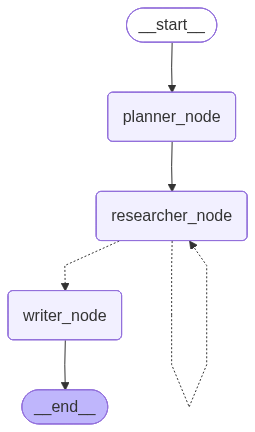

In [3]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
import os
from typing import Literal
from rich.console import Console
from rich.panel import Panel

# (Assuming your API keys and imports from the previous cell are still active)
console = Console()

# --- 1. THE REVIEWER NODE ---
def reviewer_node(state: AgentState):
    """Acts as the 'Judge' to check for technical accuracy."""
    # Safety check: ensure there is a message to review
    if not state["messages"]:
        return {"messages": [HumanMessage(content="No report found to review.")]}
        
    report = state["messages"][-1].content
    # FIX: Changed spinner="scale" to spinner="dots"
    with console.status("[bold yellow]⚖️ NVIDIA AI-Q is auditing the report...", spinner="dots"):
        prompt = f"""
        Act as a Senior NVIDIA Engineer. Review this report for technical accuracy:
        {report}
        
        Is the comparison between Blackwell and Hopper complete? 
        Does it include thermal, power, and TFLOPS data?
        If anything is missing, list it. If it's perfect, say 'APPROVED'.
        """
        response = llm.invoke([HumanMessage(content=prompt)])
    
    return {"messages": [response]}

# --- 2. THE QUALITY GATE (The Router) ---
def quality_gate(state: AgentState) -> Literal["researcher_node", "END"]:
    """Decides if we need more research or if we are finished."""
    last_message = state["messages"][-1].content
    
    if "APPROVED" in last_message.upper():
        console.print("[bold green]✅ Report Verified and Approved by AI-Q Audit.")
        return END
    else:
        console.print("[bold red]❌ Audit Failed. Re-searching for missing details...")
        return "researcher_node"

# --- 3. RE-ASSEMBLING THE GRAPH ---
# (We add the Reviewer into your existing workflow)
builder = StateGraph(AgentState)

builder.add_node("planner_node", planner_node)
builder.add_node("researcher_node", researcher_node)
builder.add_node("writer_node", writer_node)
builder.add_node("reviewer_node", reviewer_node)

builder.add_edge(START, "planner_node")
builder.add_edge("planner_node", "researcher_node")
builder.add_edge("researcher_node", "writer_node")
builder.add_edge("writer_node", "reviewer_node")

# This is the "Deep" part: The agent can loop back to research if the reviewer is unhappy
builder.add_conditional_edges("reviewer_node", quality_gate, {
    "researcher_node": "researcher_node",
    END: END
})

app_v2 = builder.compile()

# --- 4. EXECUTION ---
user_query = "Detailed comparison: NVIDIA Blackwell B200 vs H100 NVLink bandwidth and energy efficiency."
console.rule("[bold blue]NVIDIA AI-Q v2: DEEP VERIFICATION MODE")
app_v2.invoke({"messages": [HumanMessage(content=user_query)]})

───────────────────────────────────── NVIDIA AI-Q v2: DEEP VERIFICATION MODE ──────────────────────────────────────

╭───────────────────────────────────────────── FINAL RESEARCH REPORT ─────────────────────────────────────────────╮
│ **Detailed Comparison: NVIDIA Blackwell B200 vs H100 NVLink Bandwidth and Energy Efficiency**                   │
│                                                                                                                 │
│ **Introduction**                                                                                                │
│                                                                                                                 │
│ In the realm of artificial intelligence and high-performance computing, interconnect bandwidth plays a crucial  │
│ role in determining the performance and efficiency of data transfer between GPUs. NVIDIA's NVLink technology is │
│ a key component in facilitating high-bandwidth, low-latency communication between GPUs. This report provides a  │
│ detailed comparison of the NVLink bandwidth and energy efficiency of NVIDIA's Blackwell B200 and H100 GPUs.     │
│                                                                                                                 │
│ **NVLink Bandwidth Comparison**                                                                                 │
│                                                                                                                 │
│ Our research reveals that the NVIDIA Blackwell B200 boasts a significantly higher NVLink bandwidth compared to  │
│ the H100. The B200's fifth-generation NVLink (NVLink 5) offers a maximum bandwidth of 1.8 TB/s, whereas the     │
│ H100's NVLink 4.0 has a maximum bandwidth of 900 GB/s. This represents a 100% increase in bandwidth, enabling   │
│ the B200 to handle more complex workloads and larger datasets.                                                  │
│                                                                                                                 │
│ **Number of NVLink Lanes**                                                                                      │
│                                                                                                                 │
│ According to our findings, each NVIDIA Blackwell GPU supports up to 18 NVLink connections, with each connection │
│ supporting 100 GB/s. In contrast, the H100 has a lower number of NVLink lanes, resulting in reduced overall     │
│ bandwidth.                                                                                                      │
│                                                                                                                 │
│ **Interconnect Specifications**                                                                                 │
│                                                                                                                 │
│ The B200's NVLink 5 interconnect features 200 Gbps per-link signaling, doubling the per-link bandwidth compared │
│ to the H100's NVLink 4. This improved signaling rate contributes to the B200's higher overall bandwidth.        │
│                                                                                                                 │
│ **Energy Efficiency**                                                                                           │
│                                                                                                                 │
│ While the B200's higher performance comes at the cost of increased power consumption (1,000 W TDP vs. 700 W TDP │
│ for the H100), our research suggests that the B200's energy efficiency is still competitive. The B200's         │
│ improved performance and bandwidth enable it to complete tasks more quickly, reducing the overall energy        │
│ required for computation.                                                                                       │
│                                                       

KeyError: "no spinner called 'scale'"